In [ ]:
## Start to look at the weather data

# Crop out the nordics

In [ ]:
import xarray as xr
from pathlib import Path

# Path to the directory 
data_dir = Path(r"C:\Users\sebbe\Desktop\Skolsaker\Examensarbete") # use your path here

#path to new files
output_dir = data_dir / "norden_subset"
output_dir.mkdir(parents=True, exist_ok=True)

# filenames
files = {
    'tx': 'tx_ens_mean_0.25deg_reg_v31.0e.nc',
    'tn': 'tn_ens_mean_0.25deg_reg_v31.0e.nc',
    'tg': 'tg_ens_mean_0.25deg_reg_v31.0e.nc',
    'rr': 'rr_ens_mean_0.25deg_reg_v31.0e.nc',
}

# slice for Norden
lat_slice = slice(54, 72)  # south to north
lon_slice = slice(5, 33)   # west to east

# loop and save
for var, filename in files.items():
    print(f"🔄 Bearbetar {var} …")
    ds = xr.open_dataset(data_dir / filename)
    norden = ds.sel(latitude=lat_slice, longitude=lon_slice)
    out_file = output_dir / f"norden_{var}_subset.nc"
    norden.to_netcdf(
        out_file,
        format="NETCDF4",
        encoding={var: {"zlib": True, "complevel": 4}}
    )
    print(f"✅saved {out_file}")

print("🎉 all files saved in ‘norden_subset’!")


# Import dataset and quick EDA

In [ ]:
# Import everything and start checking the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)


df_daily = pd.read_sql(
    """
    SELECT time, AVG(tx) AS tx, AVG(tn) AS tn, AVG(tg) AS tg, AVG(rr) AS rr
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time
    """,
    engine,
    parse_dates=['time']
).set_index('time')

# Quick info + describe
print(df_daily.info())         
print(df_daily.describe().transpose())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27394 entries, 1950-01-01 to 2024-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tx      27394 non-null  float64
 1   tn      27394 non-null  float64
 2   tg      27394 non-null  float64
 3   rr      27394 non-null  float64
dtypes: float64(4)
memory usage: 1.0 MB
None
      count      mean       std        min       25%       50%        75%  \
tx  27394.0  6.782781  9.373737 -25.529053 -0.566667  6.255002  15.102193   
tn  27394.0 -1.011342  8.592541 -32.568713 -7.155588 -0.416847   6.361690   
tg  27394.0  2.899883  8.810058 -29.096675 -3.681233  2.824955  10.627637   
rr  27394.0  1.895686  1.371510   0.000000  0.839167  1.634140   2.666010   

          max  
tx  28.486148  
tn  16.139985  
tg  22.127795  
rr  11.385159  


In [78]:
#forgot to check null so run this again
print(df.info())

print(df_daily.isnull().sum())  
print(df.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27394 entries, 0 to 27393
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               27394 non-null  datetime64[ns]
 1   tx                 27394 non-null  float64       
 2   tn                 27394 non-null  float64       
 3   tg                 27394 non-null  float64       
 4   rr                 27394 non-null  float64       
 5   extreme_hot_tx     27394 non-null  int32         
 6   extreme_cold_tn    27394 non-null  int32         
 7   year               27394 non-null  int32         
 8   extreme_rain       27394 non-null  int32         
 9   precipitation_day  27394 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(5)
memory usage: 1.6 MB
None
tx    0
tn    0
tg    0
rr    0
dtype: int64
                     count                 mean                  min  \
time                 27394  1987-07-02 1

# Create map over area we cut out

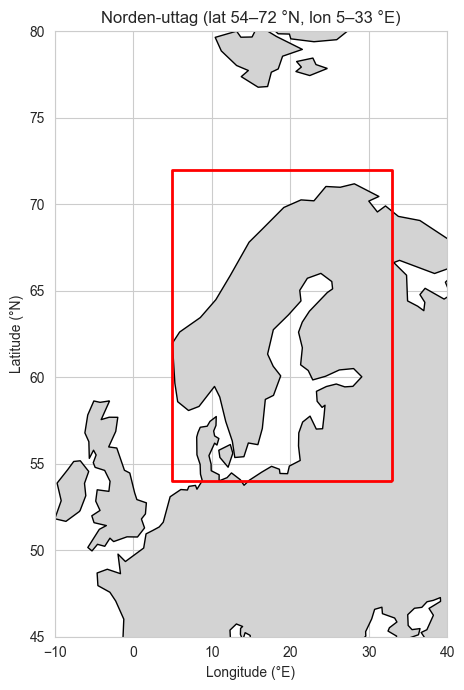

In [81]:
#Check out the area we cut out

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from geodatasets import get_path         

# read the map 
world = gpd.read_file(get_path("naturalearth.land"))

# Filter out europe 
europe = world.cx[-25:45, 35:85]          # quick bounding-box clip

# Show my area
bbox = box(5, 54, 33, 72)                 # lon_min, lat_min, lon_max, lat_max
bbox_gdf = gpd.GeoSeries([bbox], crs="EPSG:4326")

# 4) Rita karta
fig, ax = plt.subplots(figsize=(9, 7))
europe.plot(ax=ax, color="lightgray", edgecolor="black")   
bbox_gdf.boundary.plot(ax=ax, color="red", linewidth=2)    

ax.set_xlim(-10, 40)
ax.set_ylim(45, 80)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("Norden-uttag (lat 54–72 °N, lon 5–33 °E)")
plt.tight_layout()
plt.show()


# Start plotting mean temp

Coldest year: 1985, 0.76 °C
Warmest year: 2020, 5.11 °C


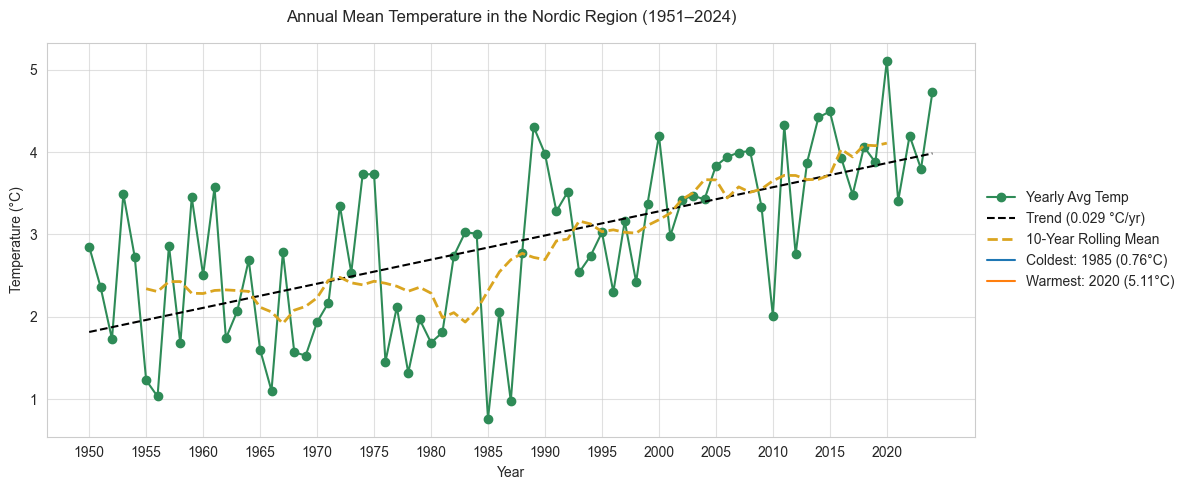

In [ ]:
import matplotlib.pyplot as plt

# Check annual mean temperature trend in the Nordic region
df_yearly = df_daily['tg'].resample('YE').mean().to_frame('avg_mean_temp')
df_yearly['year'] = df_yearly.index.year

# Compute linear trend coefficients
coeffs = np.polyfit(df_yearly['year'], df_yearly['avg_mean_temp'], 1)
trend_fn = np.poly1d(coeffs)

# Identify coldest and warmest years for legend
cold_idx = df_yearly['avg_mean_temp'].idxmin()
warm_idx = df_yearly['avg_mean_temp'].idxmax()
cold_year, cold_temp = int(df_yearly.loc[cold_idx,'year']), df_yearly.loc[cold_idx,'avg_mean_temp']
warm_year, warm_temp = int(df_yearly.loc[warm_idx,'year']), df_yearly.loc[warm_idx,'avg_mean_temp']
# Compute 10-year rolling mean (centered)
df_yearly['10yr_rolling_mean'] = df_yearly['avg_mean_temp'].rolling(window=10, center=True).mean()

print(f"Coldest year: {cold_year}, {cold_temp:.2f} °C")
print(f"Warmest year: {warm_year}, {warm_temp:.2f} °C")

# Plot with legend entries for extremes, no scatter markers
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df_yearly['year'], df_yearly['avg_mean_temp'], marker='o',color='seagreen', linewidth=1.5, label='Yearly Avg Temp')
plt.plot(df_yearly['year'], trend_fn(df_yearly['year']), linestyle='--', linewidth=1.5, color='black', label=f'Trend ({coeffs[0]:.3f} °C/yr)')
plt.plot(df_yearly['year'], df_yearly['10yr_rolling_mean'], linestyle='--', color='goldenrod', linewidth=2, label='10-Year Rolling Mean')


# Add legend entries for coldest and warmest without extra markers
plt.plot([], [], label=f'Coldest: {cold_year} ({cold_temp:.2f}°C)')
plt.plot([], [], label=f'Warmest: {warm_year} ({warm_temp:.2f}°C)')


ax.set_title('Annual Mean Temperature in the Nordic Region (1951–2024)', pad=15)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, alpha=0.6)
ax.set_xticks(df_yearly['year'][::5])

# Place legend outside
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
plt.show()


C:\Users\sebbe\AppData\Local\Temp\ipykernel_69704\2312683051.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_daily['rr'].resample('Y').sum().to_frame('annual_precip')


Driest year: 1976, 551.89 mm
Wettest year: 1998, 825.68 mm


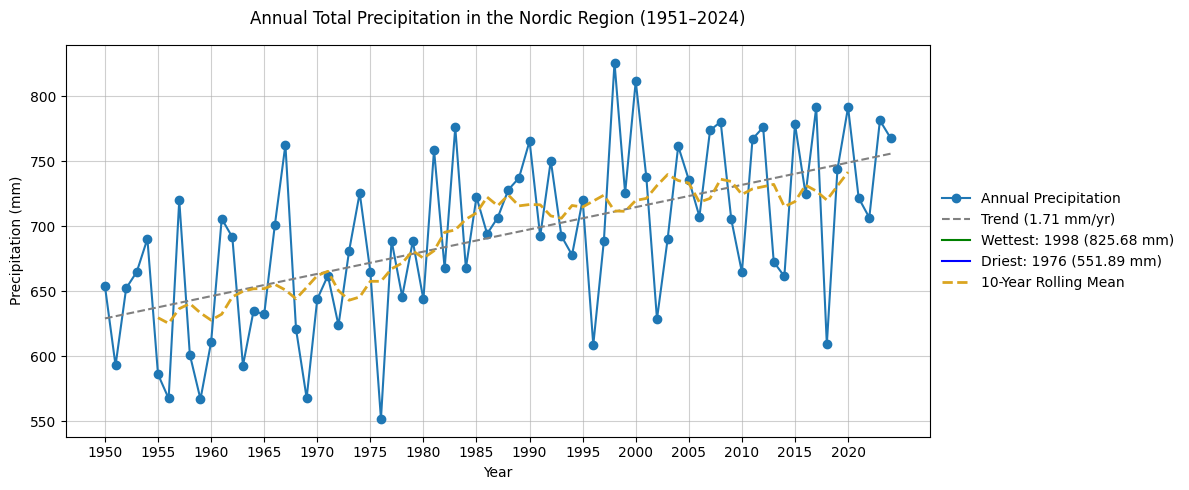

In [ ]:
# plot early total precipitation in the Nordic area 

import numpy as np
import matplotlib.pyplot as plt


# Aggregate to yearly total precipitation
df_yearly = df_daily['rr'].resample('YE').sum().to_frame('annual_precip')
df_yearly['year'] = df_yearly.index.year

# Compute linear trend coefficients
coeffs = np.polyfit(df_yearly['year'], df_yearly['annual_precip'], 1)
trend_fn = np.poly1d(coeffs)
# compute 10-year rolling mean
df_yearly['10yr_rolling_mean'] = df_yearly['annual_precip'].rolling(window=10, center=True).mean()


# Identify driest and wettest years
dry_idx = df_yearly['annual_precip'].idxmin()
wet_idx = df_yearly['annual_precip'].idxmax()
dry_year, dry_precip = int(df_yearly.loc[dry_idx,'year']), df_yearly.loc[dry_idx,'annual_precip']
wet_year, wet_precip = int(df_yearly.loc[wet_idx,'year']), df_yearly.loc[wet_idx,'annual_precip']

# Compute 10-year rolling mean


print(f"Driest year: {dry_year}, {dry_precip:.2f} mm")
print(f"Wettest year: {wet_year}, {wet_precip:.2f} mm")

# Plot with legend entries for extremes
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_yearly['year'], df_yearly['annual_precip'],
        marker='o', linewidth=1.5, label='Annual Precipitation')
ax.plot(df_yearly['year'], trend_fn(df_yearly['year']),
        linestyle='--', linewidth=1.5, color='gray',
        label=f'Trend ({coeffs[0]:.2f} mm/yr)')

# Legend-only entries for driest and wettest years
ax.plot([], [], color='green', label=f'Wettest: {wet_year} ({wet_precip:.2f} mm)')
ax.plot([], [], color='blue', label=f'Driest: {dry_year} ({dry_precip:.2f} mm)')
ax.set_title('Annual Total Precipitation in the Nordic Region (1951–2024)', pad=15)
plt.plot(df_yearly['year'], df_yearly['10yr_rolling_mean'], linestyle='--', color='goldenrod', linewidth=2, label='10-Year Rolling Mean')

ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
ax.grid(True, alpha=0.6)
ax.set_xticks(df_yearly['year'][::5])

# Legend outside
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
plt.show()


# Plotting monthly average temp

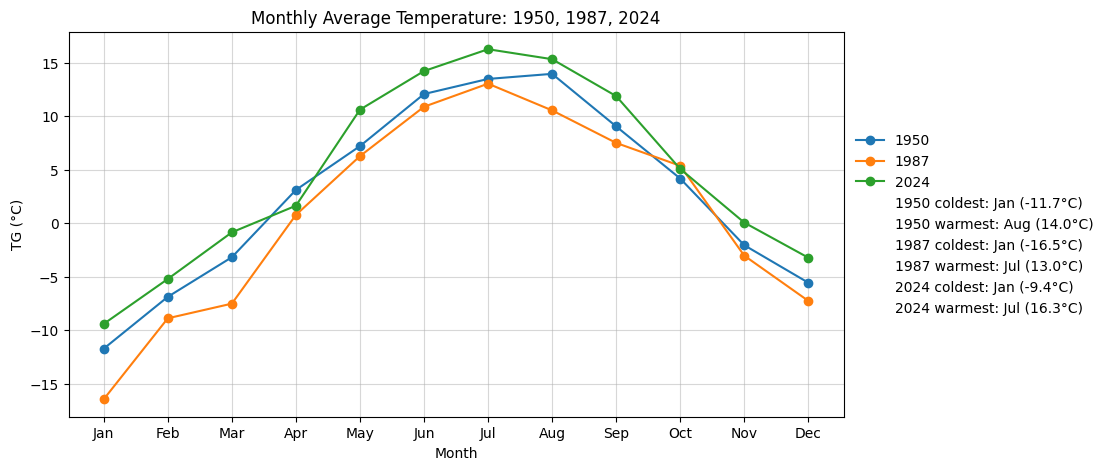

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

#load daily data 
df_daily = pd.read_sql(
    """
    SELECT time, AVG(tg) AS tg
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')

# Prepare years
years_to_plot = [1950, 1987, 2024]
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Compute profiles and extremes
profiles, extremes = {}, {}
for yr in years_to_plot:
    monthly = df_daily[df_daily.index.year == yr]['tg'].resample('ME').mean()
    monthly.index = monthly.index.month
    monthly = monthly.reindex(range(1,13))
    profiles[yr] = monthly.values
    mi, ma = monthly.min(), monthly.max()
    mseas_min, mseas_max = monthly.idxmin(), monthly.idxmax()
    extremes[yr] = (mseas_min, mi, mseas_max, ma)

# Plot
plt.figure(figsize=(10,5))
for yr in years_to_plot:
    plt.plot(range(1,13), profiles[yr], marker='o', label=str(yr))

# Legend entries for extremes
for yr in years_to_plot:
    mn, mnv, mx, mxv = extremes[yr]
    plt.plot([], [], ' ', label=f'{yr} coldest: {month_names[mn-1]} ({mnv:.1f}°C)')
    plt.plot([], [], ' ', label=f'{yr} warmest: {month_names[mx-1]} ({mxv:.1f}°C)')

plt.title('Monthly Average Temperature: 1950, 1987, 2024')
plt.xlabel('Month')
plt.ylabel('TG (°C)')
plt.xticks(range(1,13), month_names)
plt.grid(alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()


# Check correlation between temp and precipitation and Anomalis

In [10]:
# Check correlation between temperature and precipitation
# Need to read in the data again 
df = pd.read_sql(
    """
    SELECT time, AVG(tg) AS tg, AVG(tx) AS tx, AVG(tn) AS tn, AVG(rr) AS rr
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')

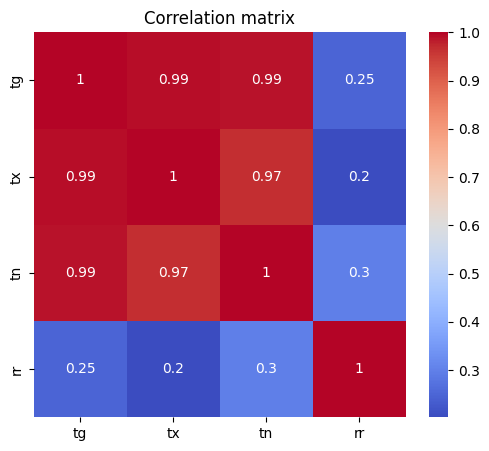

In [11]:
corr = df[['tg','tx','tn','rr']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

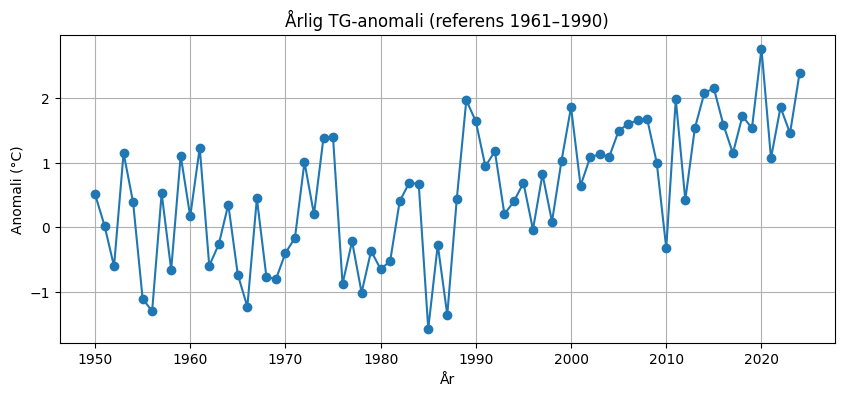

In [54]:
ref = pd.read_sql(
    "SELECT AVG(tg) AS ref_tg FROM dbo.ClimateData_Norden "
    "WHERE time BETWEEN '1961-01-01' AND '1990-12-31';",
    engine
)
ref_tg = ref['ref_tg'][0]

# Beräkna årsmedeltemperatur (TG)
df_yearly_tg = pd.read_sql(
    "SELECT YEAR(time) AS year, AVG(tg) AS avg_tg "
    "FROM dbo.ClimateData_Norden "
    "GROUP BY YEAR(time) ORDER BY YEAR(time);",
    engine
)

# Lägg till anomali-kolumn i df_yearly_tg
df_yearly_tg['tg_anomaly'] = df_yearly_tg['avg_tg'] - ref_tg

# Plot anomalierna
# %%
plt.figure(figsize=(10,4))
plt.plot(df_yearly_tg['year'], df_yearly_tg['tg_anomaly'], marker='o')
plt.title('Årlig TG-anomali (referens 1961–1990)')
plt.xlabel('År')
plt.ylabel('Anomali (°C)')
plt.grid(True)
plt.show()

In [ ]:
# Find extreme values 5th and 95th percentiles for TX, TN and RR
95:e percentil TX = 23.20 °C, TN = 12.58 °C, RR = 8.90 mm

5:e percentil TN = -20.37 °C

###

# Find "extreme" values and plot

In [25]:
##################################################################
##df to find for extreme values 5th and 95th percentiles for TX, TN and RR
percentiles = pd.read_sql("""
    SELECT DISTINCT
        PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY tx) OVER () AS tx_95,
        PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY rr) OVER () AS rr_90,
        PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY tn) OVER () AS tn_05
    FROM dbo.ClimateData_Norden;
""", engine).iloc[0]

tx_95 = percentiles['tx_95']
rr_90 = percentiles['rr_90']
tn_05 = percentiles['tn_05']
print(f"95:e percentil TX = {tx_95:.2f} °C, RR = {rr_90:.2f} mm")
print(f"5:e percentil TN = {tn_05:.2f} °C")


95:e percentil TX = 23.20 °C, RR = 5.80 mm
5:e percentil TN = -20.37 °C


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# read the data again
engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df_daily = pd.read_sql(
    """
    SELECT time, AVG(tx) AS tx, AVG(tn) AS tn
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')

# calculate 5th and 95th percentiles
percentiles = pd.read_sql("""
    SELECT DISTINCT
      PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY tx) OVER () AS tx_95,
      PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY tn) OVER () AS tn_05
    FROM dbo.ClimateData_Norden;
""", engine).iloc[0]
tx_95 = percentiles.tx_95
tn_05 = percentiles.tn_05




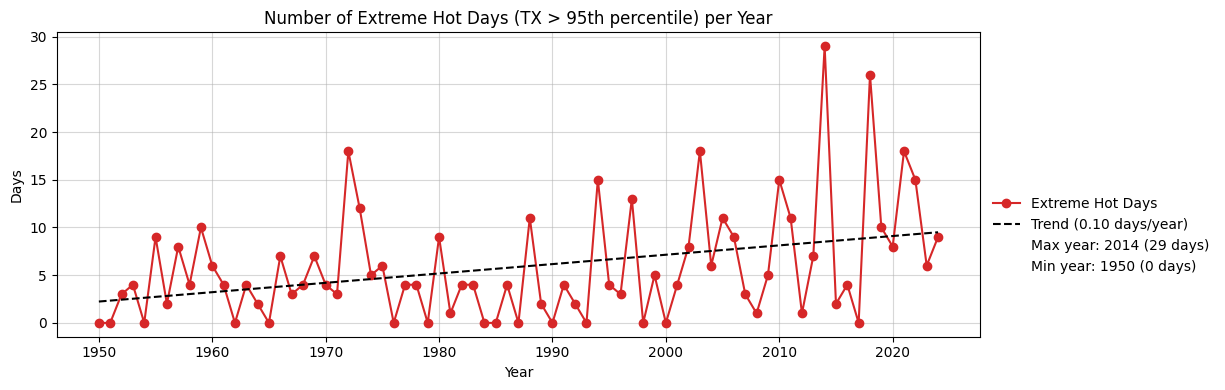

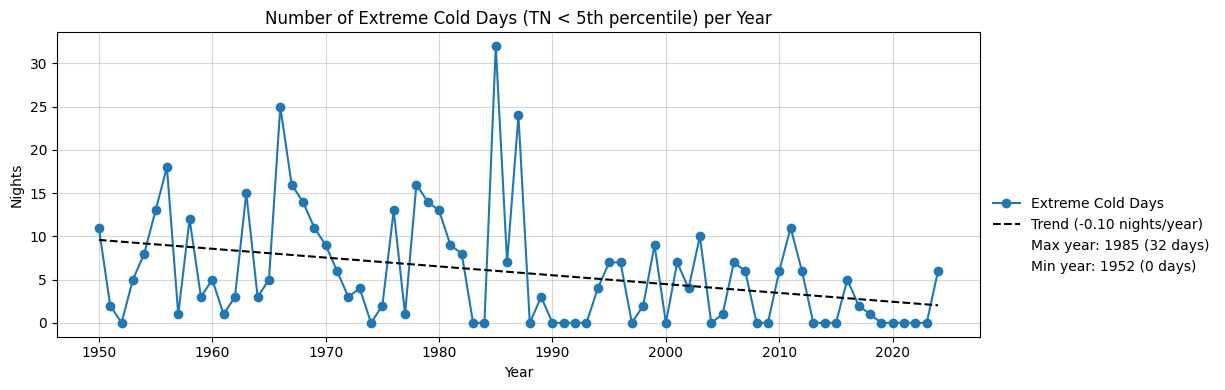

In [37]:
# find extreme values
df_daily['extreme_hot_tx']  = (df_daily['tx'] >= tx_95).astype(int)
df_daily['extreme_cold_tn'] = (df_daily['tn'] <= tn_05).astype(int)
df_daily['year'] = df_daily.index.year

#  group by year and sum extreme values
extreme_hot_tx_per_year  = df_daily.groupby('year')['extreme_hot_tx'].sum().reset_index()
extreme_cold_tn_per_year = df_daily.groupby('year')['extreme_cold_tn'].sum().reset_index()

# extreme hot days
years_hot  = extreme_hot_tx_per_year.year.values
counts_hot = extreme_hot_tx_per_year.extreme_hot_tx.values

# find min and max
idx_max_hot = counts_hot.argmax()
idx_min_hot = counts_hot.argmin()
year_max_hot = years_hot[idx_max_hot]
year_min_hot = years_hot[idx_min_hot]

# Trend
c_hot = np.polyfit(years_hot, counts_hot, 1)
trend_hot = np.poly1d(c_hot)(years_hot)

plt.figure(figsize=(10,4))
plt.plot(years_hot, counts_hot, marker='o', color='tab:red', label='Extreme Hot Days')
plt.plot(years_hot, trend_hot, '--', color='black',
         label=f'Trend ({c_hot[0]:.2f} days/year)')


plt.plot([], [], ' ', label=f'Max year: {year_max_hot} ({counts_hot[idx_max_hot]} days)')
plt.plot([], [], ' ', label=f'Min year: {year_min_hot} ({counts_hot[idx_min_hot]} days)')

plt.title('Number of Extreme Hot Days (TX > 95th percentile) per Year')
plt.xlabel('Year')
plt.ylabel('Days')
plt.legend(loc='upper left', frameon=False)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()


# find the cold days
years_cold  = extreme_cold_tn_per_year.year.values
counts_cold = extreme_cold_tn_per_year.extreme_cold_tn.values

idx_max_cold = counts_cold.argmax()
idx_min_cold = counts_cold.argmin()
year_max_cold = years_cold[idx_max_cold]
year_min_cold = years_cold[idx_min_cold]

c_cold = np.polyfit(years_cold, counts_cold, 1)
trend_cold = np.poly1d(c_cold)(years_cold)

# plot 
plt.figure(figsize=(10,4))
plt.plot(years_cold, counts_cold, marker='o', color='tab:blue', label='Extreme Cold Days')
plt.plot(years_cold, trend_cold, '--', color='black',
         label=f'Trend ({c_cold[0]:.2f} nights/year)')

plt.plot([], [], ' ', label=f'Max year: {year_max_cold} ({counts_cold[idx_max_cold]} days)')
plt.plot([], [], ' ', label=f'Min year: {year_min_cold} ({counts_cold[idx_min_cold]} days)')

plt.title('Number of Extreme Cold Days (TN < 5th percentile) per Year')
plt.xlabel('Year')
plt.ylabel('Nights')
plt.legend(loc='upper left', frameon=False)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()

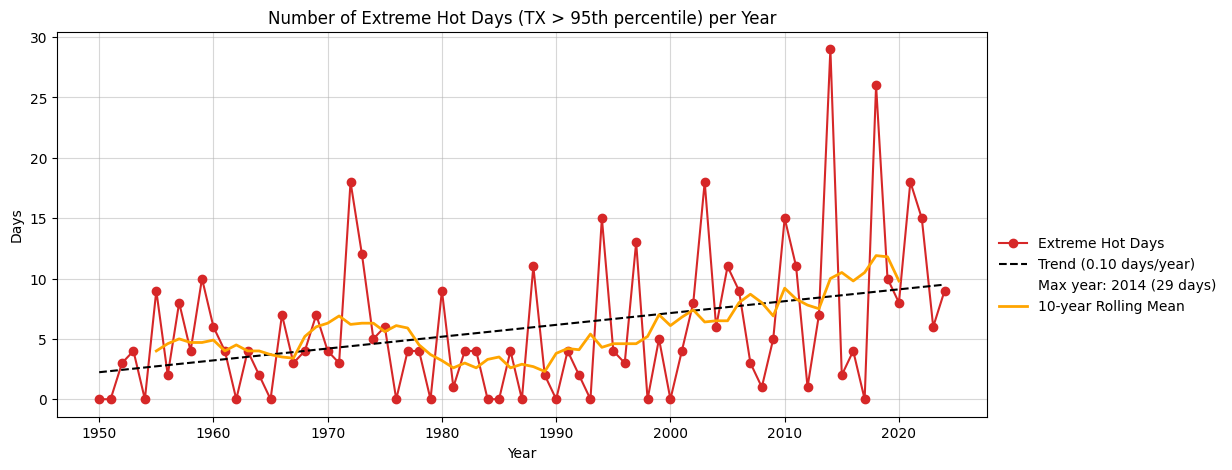

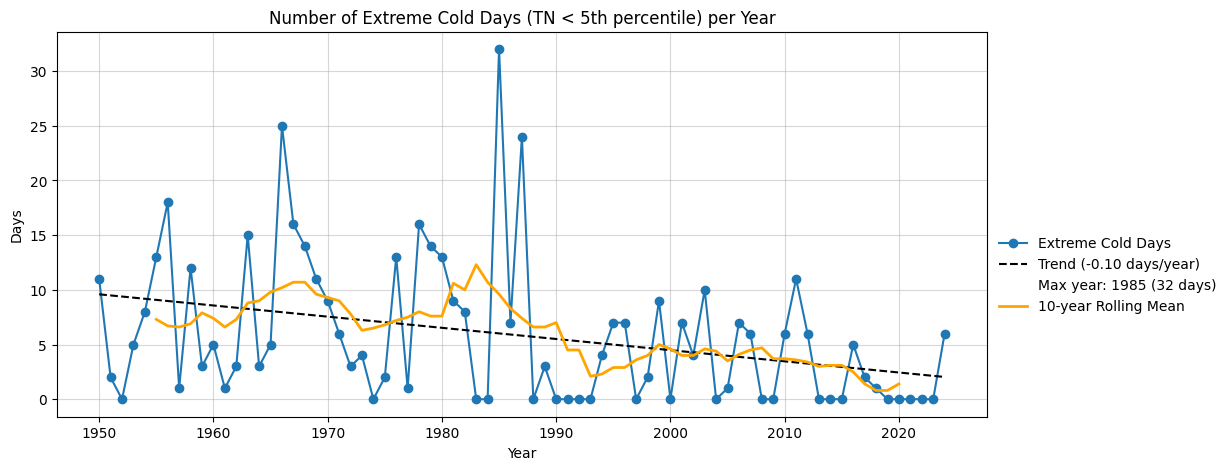

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# find extreme values
df_daily['extreme_hot_tx']  = (df_daily['tx'] >= tx_95).astype(int)
df_daily['extreme_cold_tn'] = (df_daily['tn'] <= tn_05).astype(int)
df_daily['year'] = df_daily.index.year

#  group by year and sum extreme values
extreme_hot_tx_per_year  = df_daily.groupby('year')['extreme_hot_tx'].sum().reset_index()
extreme_cold_tn_per_year = df_daily.groupby('year')['extreme_cold_tn'].sum().reset_index()

# extreme hot days
years_hot  = extreme_hot_tx_per_year.year.values
counts_hot = extreme_hot_tx_per_year.extreme_hot_tx.values

# find min and max
idx_max_hot = counts_hot.argmax()
idx_min_hot = counts_hot.argmin()
year_max_hot = years_hot[idx_max_hot]
year_min_hot = years_hot[idx_min_hot]

# Trend
c_hot = np.polyfit(years_hot, counts_hot, 1)
trend_hot = np.poly1d(c_hot)(years_hot)

years  = extreme_hot_tx_per_year['year']
counts = extreme_hot_tx_per_year['extreme_hot_tx']
coeffs = np.polyfit(years, counts, 1)
trend  = np.poly1d(coeffs)

# Identify max year
idx_max = counts.idxmax()
year_max = years.iloc[idx_max]
count_max = counts.iloc[idx_max]



extreme_hot_tx_per_year['rolling_10yr'] = counts.rolling(window=10, center=True).mean()

plt.figure(figsize=(12,5))
plt.plot(years_hot, counts_hot, marker='o', color='tab:red', label='Extreme Hot Days')
plt.plot(years_hot, trend_hot, '--', color='black', label=f'Trend ({c_hot[0]:.2f} days/year)')
plt.plot([], [], ' ', label=f'Max year: {year_max_hot} ({counts_hot[idx_max_hot]} days)')
#plt.plot([], [], ' ', label=f'Min year: {year_min_hot} ({counts_hot[idx_min_hot]} days)')
plt.plot(extreme_hot_tx_per_year['year'], extreme_hot_tx_per_year['rolling_10yr'],'-', color='orange', lw=2, label='10-year Rolling Mean')

plt.title('Number of Extreme Hot Days (TX > 95th percentile) per Year')
plt.xlabel('Year')
plt.ylabel('Days')
plt.grid(alpha=0.5)

# Legend outside to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()


# find the cold days
years_cold  = extreme_cold_tn_per_year.year.values
counts_cold = extreme_cold_tn_per_year.extreme_cold_tn.values

idx_max_cold = counts_cold.argmax()
idx_min_cold = counts_cold.argmin()
year_max_cold = years_cold[idx_max_cold]
year_min_cold = years_cold[idx_min_cold]

c_cold = np.polyfit(years_cold, counts_cold, 1)
trend_cold = np.poly1d(c_cold)(years_cold)
years  = extreme_cold_tn_per_year['year']
counts = extreme_cold_tn_per_year['extreme_cold_tn']
coeffs = np.polyfit(years, counts, 1)
trend  = np.poly1d(coeffs)



extreme_cold_tn_per_year['rolling_10yr'] = counts.rolling(window=10, center=True).mean()


# plot 
plt.figure(figsize=(12,5))
plt.plot(years_cold, counts_cold, marker='o', color='tab:blue', label='Extreme Cold Days')
plt.plot(years_cold, trend_cold, '--', color='black', label=f'Trend ({c_cold[0]:.2f} days/year)')
plt.plot([], [], ' ', label=f'Max year: {year_max_cold} ({counts_cold[idx_max_cold]} days)')
#plt.plot([], [], ' ', label=f'Min year: {year_min_cold} ({counts_cold[idx_min_cold]} days)')

plt.plot(extreme_cold_tn_per_year['year'], extreme_cold_tn_per_year['rolling_10yr'],'-', color='orange', lw=2, label='10-year Rolling Mean')

plt.title('Number of Extreme Cold Days (TN < 5th percentile) per Year')
plt.xlabel('Year')
plt.ylabel('Days')
plt.grid(alpha=0.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()


In [ ]:
# Tried with 95th perecentile for RR but did not show a lot.. Changed treshold to 90th percentile

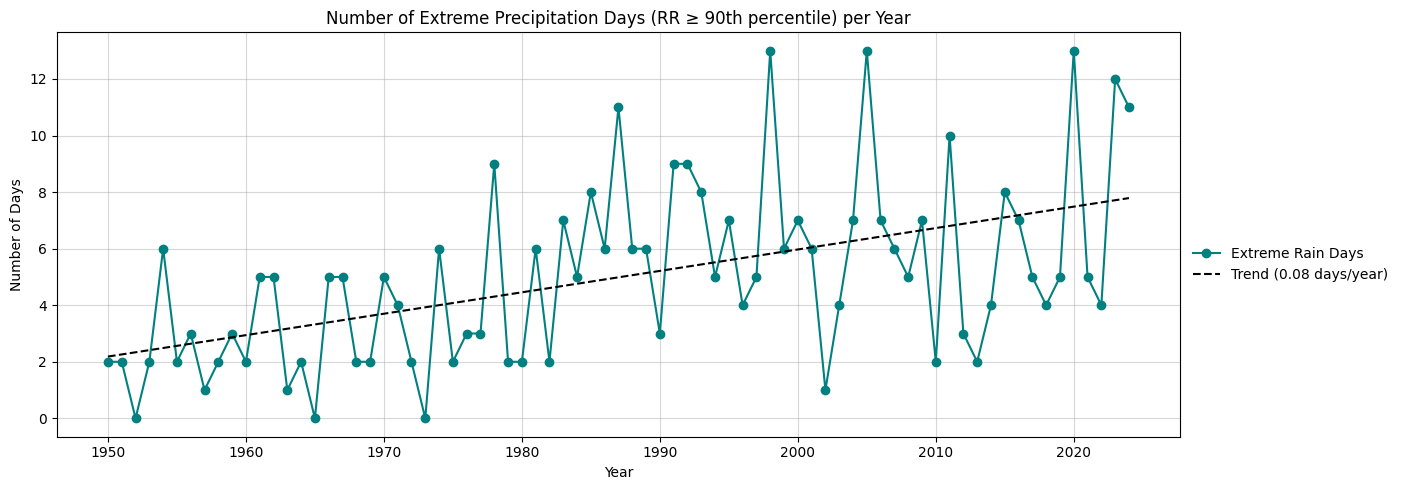

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Reload daily-mean DataFrame (tg, tx, tn, rr) from SQL
engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df = pd.read_sql(
    """
    SELECT time,
           AVG(tx) AS tx,
           AVG(tn) AS tn,
           AVG(tg) AS tg,
           AVG(rr) AS rr
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
)

#  Read percentiles (already done, but repeat for clarity)
pct = pd.read_sql(
    """
    SELECT DISTINCT
      PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY rr) OVER () AS rr_90
    FROM dbo.ClimateData_Norden;
    """,
    engine
).iloc[0]
rr_90 = pct.rr_90

# Flag extreme‐rain days and extract year
df['extreme_rain'] = (df['rr'] >= rr_90).astype(int)
df['year'] = df['time'].dt.year

#  Aggregate to yearly counts
extreme_rain_per_year = (
    df.groupby('year')['extreme_rain']
      .sum()
      .reset_index()
)

# Fit linear trend
years  = extreme_rain_per_year['year'].values
counts = extreme_rain_per_year['extreme_rain'].values
coeffs = np.polyfit(years, counts, 1)
trend  = np.poly1d(coeffs)

# Plot
plt.figure(figsize=(12,5))
plt.plot(years, counts, marker='o', color='teal', label='Extreme Rain Days')
plt.plot(years, trend(years), '--', color='black',
         label=f'Trend ({coeffs[0]:.2f} days/year)')
plt.title('Number of Extreme Precipitation Days (RR ≥ 90th percentile) per Year')
plt.plot([], [], ' ', label=f'Max year: {year_max} ({count_max} days)')

plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend(loc='upper left', frameon=False)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()


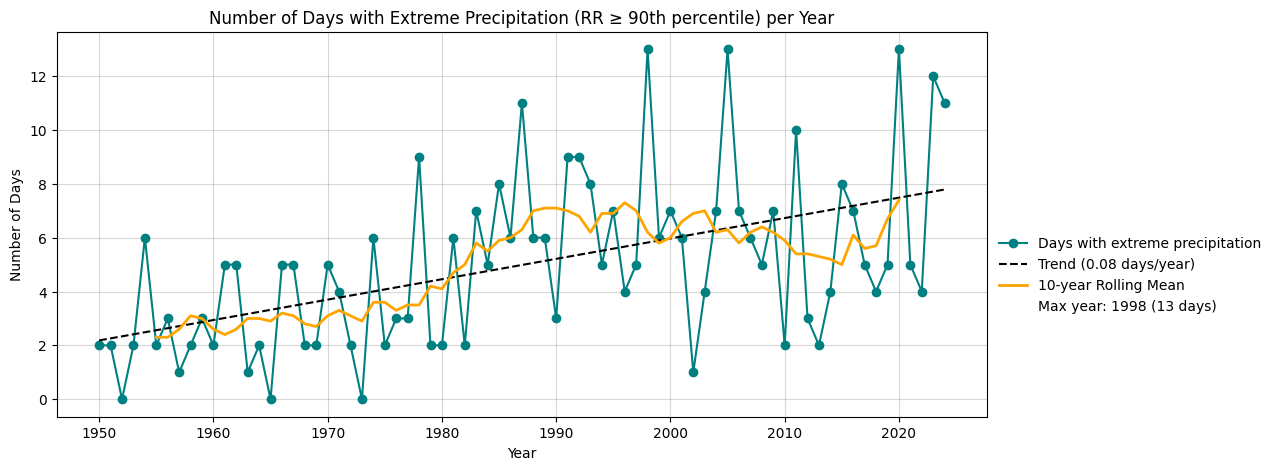

In [ ]:

#Read 90th percentile for rr
rr_90 = pd.read_sql(
    "SELECT DISTINCT PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY rr) OVER () AS rr_90 FROM dbo.ClimateData_Norden;",
    engine
).iloc[0].rr_90

# Flag extremes and extract year
df['extreme_rain'] = (df['rr'] >= rr_90).astype(int)
df['year'] = df['time'].dt.year

# Aggregate yearly counts
extreme_rain_per_year = df.groupby('year')['extreme_rain'].sum().reset_index()

#  Trend line
years  = extreme_rain_per_year['year']
counts = extreme_rain_per_year['extreme_rain']
coeffs = np.polyfit(years, counts, 1)
trend  = np.poly1d(coeffs)

# Identify max year
idx_max = counts.idxmax()
year_max = years.iloc[idx_max]
count_max = counts.iloc[idx_max]

# 10-year rolling mean
extreme_rain_per_year['rolling_10yr'] = counts.rolling(window=10, center=True).mean()

# Plot
plt.figure(figsize=(12,5))
plt.plot(years, counts, 'o-', color='teal', label='Days with extreme precipitation')
plt.plot(years, trend(years), '--k', label=f'Trend ({coeffs[0]:.2f} days/year)')
plt.plot(extreme_rain_per_year['year'], extreme_rain_per_year['rolling_10yr'],'-', color='orange', lw=2, label='10-year Rolling Mean')
plt.plot([], [], ' ', label=f'Max year: {year_max} ({count_max} days)')

plt.title('Number of Days with Extreme Precipitation (RR ≥ 90th percentile) per Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.grid(alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1,0.5), frameon=False)
plt.show()

In [8]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

df_daily = pd.read_sql(
    """
    SELECT time, AVG(tx) AS tx, AVG(tn) AS tn, AVG(tg) AS tg, AVG(rr) AS rr
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')


C:\Users\sebbe\AppData\Local\Temp\ipykernel_69704\3404309346.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  heavy_rain_per_year = df_daily['heavy_rain'].resample('Y').sum().to_frame('days')


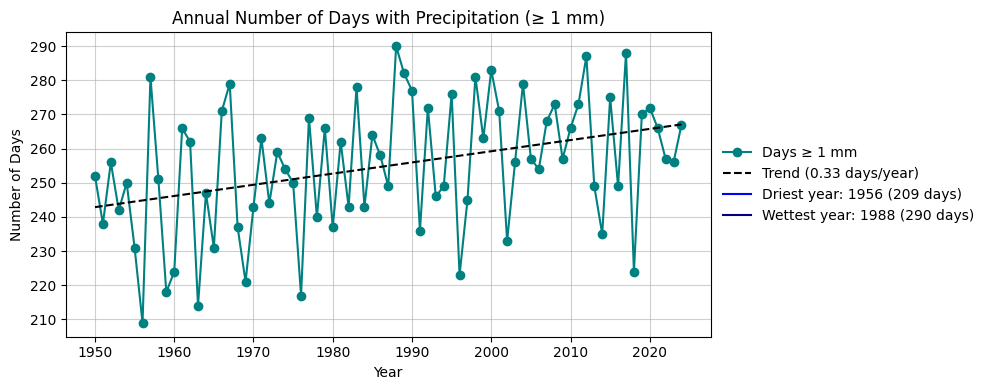

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Mark mark days with precpitation ≥ 1 mm
df_daily['heavy_rain'] = (df_daily['rr'] >= 1.0).astype(int)

# Aggregate to annual heavy-rain-day counts
heavy_rain_per_year = df_daily['heavy_rain'].resample('Y').sum().to_frame('days')
heavy_rain_per_year['year'] = heavy_rain_per_year.index.year

# 3) Compute linear trend (days per year)
years = heavy_rain_per_year['year'].values
counts = heavy_rain_per_year['days'].values
coeffs = np.polyfit(years, counts, 1)
trend = np.poly1d(coeffs)(years)

# Identify min/max
min_idx = np.argmin(counts)
max_idx = np.argmax(counts)
min_year, min_days = years[min_idx], counts[min_idx]
max_year, max_days = years[max_idx], counts[max_idx]

# plot

plt.figure(figsize=(10,4))
plt.plot(years, counts, marker='o', color='teal', label='Days ≥ 1 mm')
plt.plot(years, trend, ls='--', color='black',
         label=f'Trend ({coeffs[0]:.2f} days/year)')

# Legend‐only entries for driest and wettest year
plt.plot([], [], color='blue',
         label=f'Driest year: {int(min_year)} ({min_days} days)')
plt.plot([], [], color='navy',
         label=f'Wettest year: {int(max_year)} ({max_days} days)')

plt.title('Annual Number of Days with Precipitation (≥ 1 mm)')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.grid(True, alpha=0.6)

# Legend outside on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)


# Count and barplot number of extreme days

In [26]:
# Mark extreme dar
df['extreme_hot_tx'] = (df['tx'] >= tx_95).astype(int)
df['extreme_cold_tn'] = (df['tn'] <= tn_05).astype(int)
df['extreme_rain'] = (df['rr'] >= rr_90).astype(int)

# Add year and month columns
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# Count extreme days per year
extreme_hot_tx_per_year = df.groupby('year')['extreme_hot_tx'].sum().reset_index()

extreme_cold_tn_per_year = df.groupby('year')['extreme_cold_tn'].sum().reset_index()

extreme_rain_per_year = df.groupby('year')['extreme_rain'].sum().reset_index()
# Distribution over months
extreme_hot_tx_per_month = df.groupby('month')['extreme_hot_tx'].sum().reset_index()
extreme_cold_tn_per_month = df.groupby('month')['extreme_cold_tn'].sum().reset_index()
extreme_rain_per_month = df.groupby('month')['extreme_rain'].sum().reset_index()


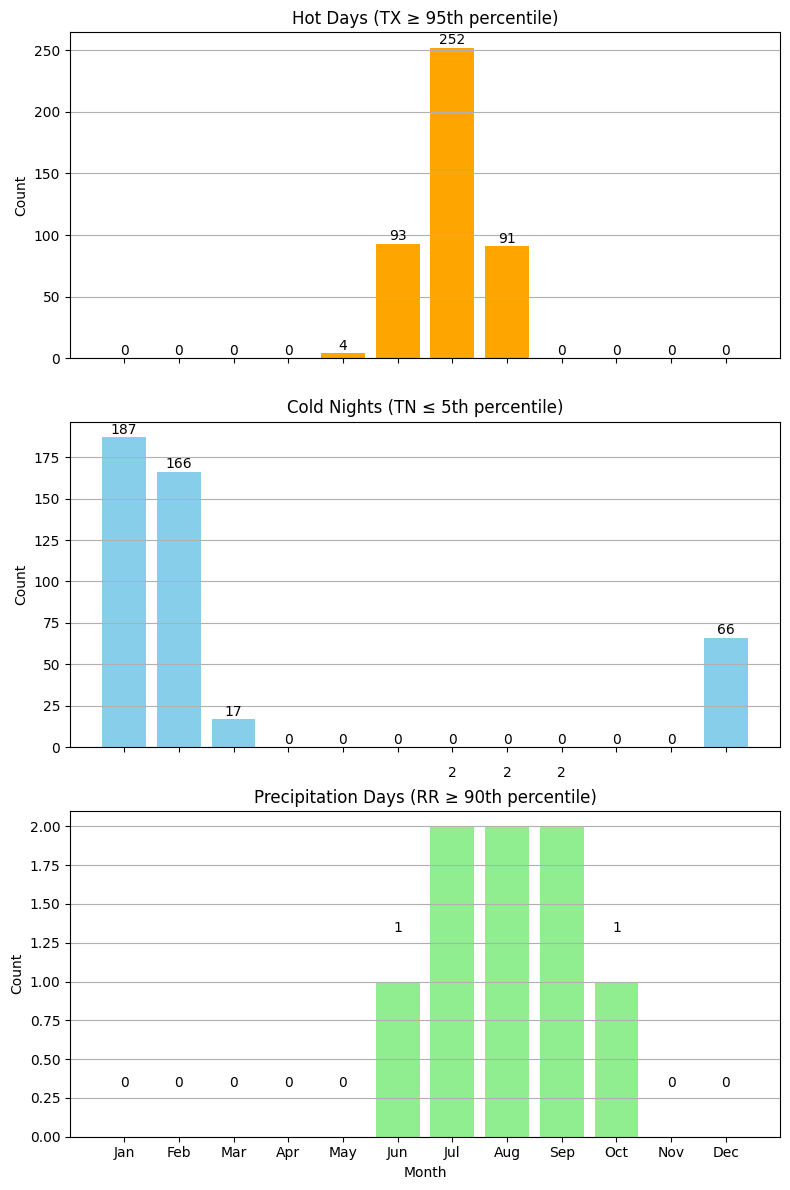

In [ ]:
import matplotlib.pyplot as plt

def add_labels(ax, x, y, spacing=0.3):
    for xi, yi in zip(x, y):
        ax.text(xi, yi + spacing, yi, ha='center', va='bottom')

# prepare your data
x_hot   = extreme_hot_tx_per_month['month']
y_hot   = extreme_hot_tx_per_month['extreme_hot_tx']
x_cold  = extreme_cold_tn_per_month['month']
y_cold  = extreme_cold_tn_per_month['extreme_cold_tn']
x_rain  = extreme_rain_per_month['month']
y_rain  = extreme_rain_per_month['extreme_rain']

# create a 3-row, 1-column figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True)

#  Extreme Hot Days
axes[0].bar(x_hot, y_hot, color='orange')
add_labels(axes[0], x_hot, y_hot)
axes[0].set_ylabel('Count')
axes[0].set_title('Hot Days (TX ≥ 95th percentile)')
axes[0].grid(axis='y')

# Extreme Cold Nights
axes[1].bar(x_cold, y_cold, color='skyblue')
add_labels(axes[1], x_cold, y_cold)
axes[1].set_ylabel('Count')
axes[1].set_title('Cold Nights (TN ≤ 5th percentile)')
axes[1].grid(axis='y')

# Extreme Precipitation
axes[2].bar(x_rain, y_rain, color='lightgreen')
add_labels(axes[2], x_rain, y_rain)
axes[2].set_ylabel('Count')
axes[2].set_title('Precipitation Days (RR ≥ 90th percentile)')
axes[2].grid(axis='y')

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axes[2].set_xticks(x_rain)
axes[2].set_xticklabels(months)

# layout tweaks
plt.xlabel('Month')
plt.tight_layout()
plt.show()


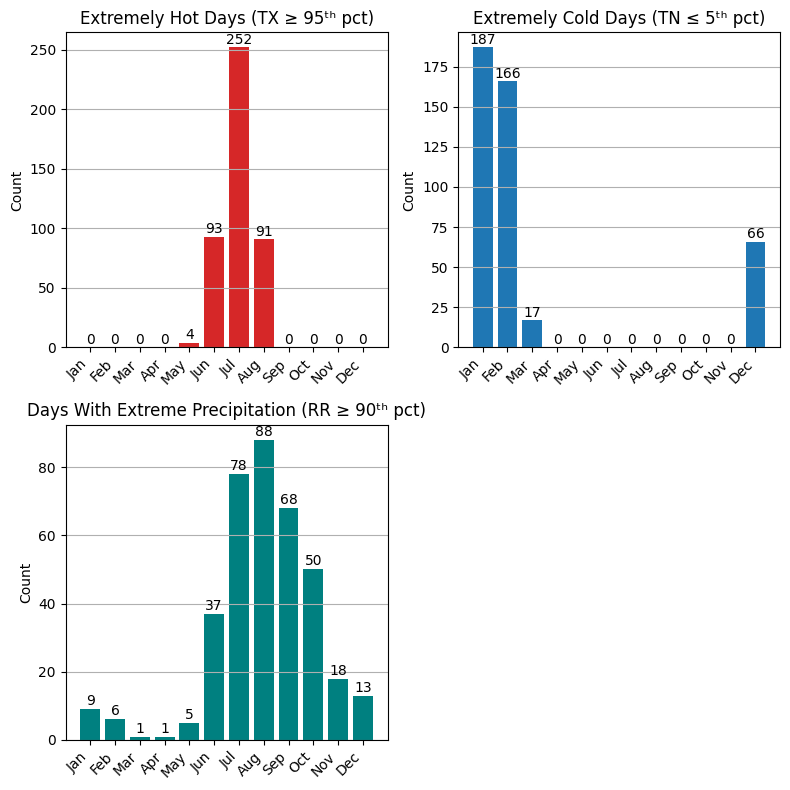

In [ ]:
# Put all extreme values in one figure

import matplotlib.pyplot as plt

def add_labels(ax, x, y, spacing=0.3):
    for xi, yi in zip(x, y):
        ax.text(xi, yi + spacing, yi, ha='center', va='bottom')

# data
x_hot   = extreme_hot_tx_per_month['month']
y_hot   = extreme_hot_tx_per_month['extreme_hot_tx']
x_cold  = extreme_cold_tn_per_month['month']
y_cold  = extreme_cold_tn_per_month['extreme_cold_tn']
x_rain  = extreme_rain_per_month['month']
y_rain  = extreme_rain_per_month['extreme_rain']

# subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# Hot days
axes[0].bar(x_hot, y_hot, color='tab:red')
add_labels(axes[0], x_hot, y_hot)
axes[0].set_title('Extremely Hot Days (TX ≥ 95ᵗʰ pct)')
axes[0].grid(axis='y')

# Cold days
axes[1].bar(x_cold, y_cold, color='tab:blue')
add_labels(axes[1], x_cold, y_cold)
axes[1].set_title('Extremely Cold Days (TN ≤ 5ᵗʰ pct)')
axes[1].grid(axis='y')

# Precipitation
axes[2].bar(x_rain, y_rain, color='teal')
add_labels(axes[2], x_rain, y_rain)
axes[2].set_title('Days With Extreme Precipitation (RR ≥ 90ᵗʰ pct)')
axes[2].grid(axis='y')


axes[3].axis('off')

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for ax in axes:
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


# STL decomposition

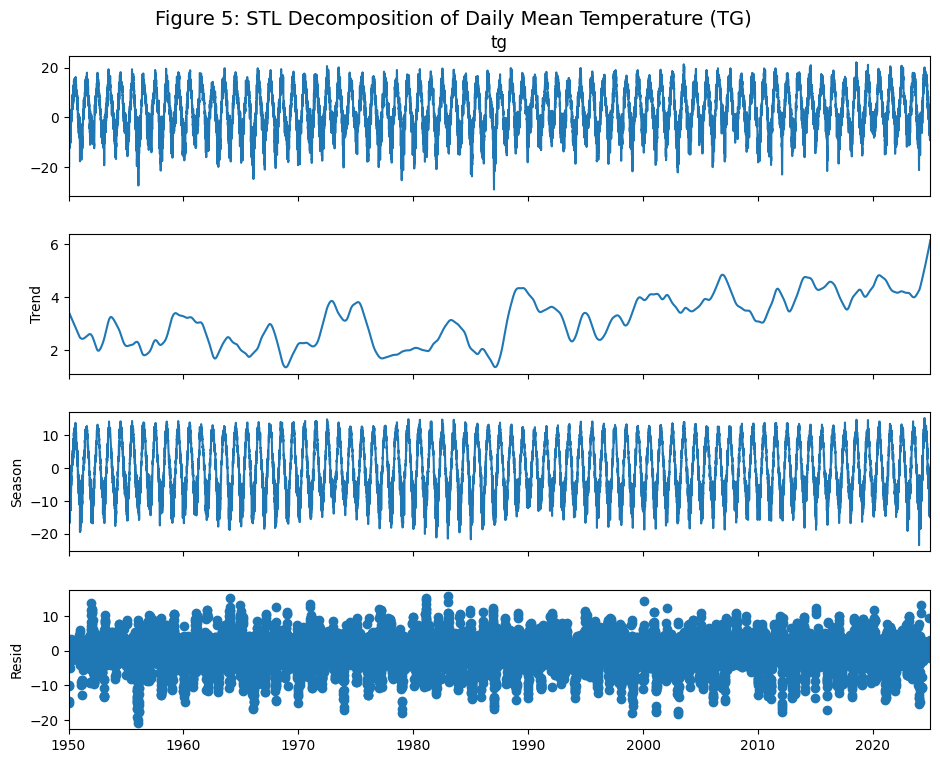

In [ ]:
# Time for a quick STL to see seasonal patterns in temperature
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Assumes df_daily is already loaded and indexed by date, with column 'tg'
series = df_daily['tg']

# Perform STL decomposition
stl = STL(series, period=365, robust=True)
res = stl.fit()

# plot
fig = res.plot()
fig.set_size_inches(10, 8)
plt.suptitle("Figure 5: STL Decomposition of Daily Mean Temperature (TG)", fontsize=14)
axes[3].scatter(res.resid.index, res.resid, s=0.5, alpha=0.6)
plt.show()


# Start building models, try with a supersimple Holt-Winters first

In [ ]:
# First we start with Holt-Winters
# Holt-Winters method for seasonal data

# Decided to just use SARIMA and try to forecast the next 10 years

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Create SQLAlchemy engine
engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df = pd.read_sql(
    "SELECT time, AVG(tx) AS tx "
    "FROM dbo.ClimateData_Norden "
    "GROUP BY time ORDER BY time;",
    engine,
    parse_dates=['time']
)
df.set_index('time', inplace=True)
df.index = pd.DatetimeIndex(df.index, freq='D')




In [62]:
# Train-test split
train = df[:'2014-12-31']['tx']
test  = df['2015-01-01':]['tx']

In [ ]:
# Fit Holt–Winters (additive trend & seasonality)
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=365
).fit(optimized=True)

# In-sample fitted values & out-of-sample forecast
fitted = hw_model.fittedvalues
forecast = hw_model.forecast(len(test))

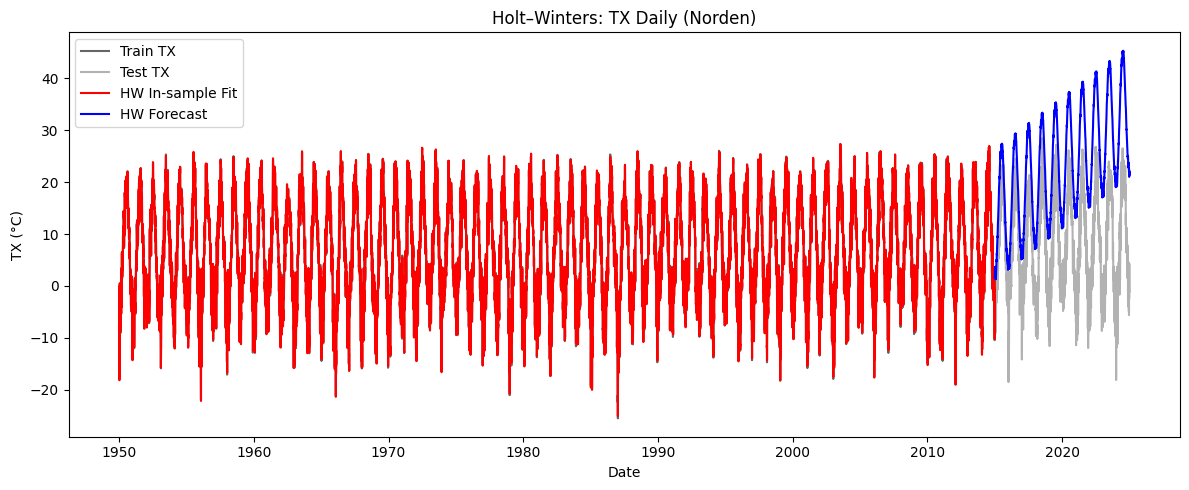

In [ ]:
# Plot results
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train TX', color='black', alpha=0.6)
plt.plot(test.index, test, label='Test TX',  color='gray', alpha=0.6)
plt.plot(fitted.index, fitted, label='HW In-sample Fit', color='red')
plt.plot(forecast.index, forecast, label='HW Forecast',   color='blue')
plt.title('Holt–Winters: TX Daily (Norden)')
plt.xlabel('Date')
plt.ylabel('TX (°C)')
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Test MAE: {mae:.3f} °C")
print(f"Test RMSE: {rmse:.3f} °C")

Test MAE: 15.475 °C
Test RMSE: 16.850 °C


In [ ]:
# Daily forecast was a no bueno, also read that Holt-Winters is not the best for long-term forecasting, so let's try SARIMA

# Deciding which SARIMA model to build (find which parameters)

C:\Users\sebbe\AppData\Local\Temp\ipykernel_91404\3832699917.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['tx'].resample('M').mean()


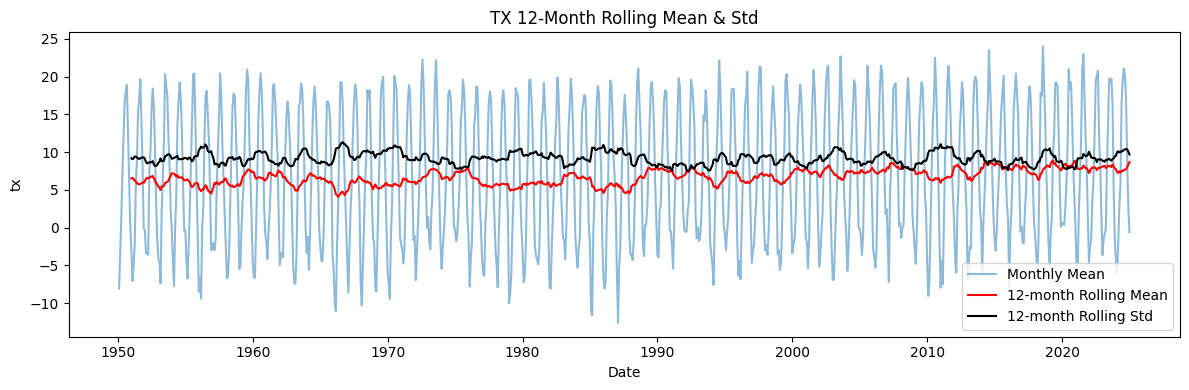

ADF Statistic: -4.3152942522052395
p-value: 0.0004178888487131505


In [ ]:
df.index = pd.to_datetime(df.index)
monthly = df['tx'].resample('M').mean()

#  12 months rolling mean and std
rol_mean = monthly.rolling(window=12).mean()
rol_std  = monthly.rolling(window=12).std()

# Plotta
plt.figure(figsize=(12,4))
plt.plot(monthly,    label='Monthly Mean',    alpha=0.5)
plt.plot(rol_mean,   label='12-month Rolling Mean',  color='red')
plt.plot(rol_std,    label='12-month Rolling Std',   color='black')
plt.legend()
plt.title('TX 12-Month Rolling Mean & Std')
plt.xlabel('Date')
plt.ylabel('tx')
plt.tight_layout()
plt.show()

#  ADF-test and p-value
adf_result = adfuller(monthly.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:',       adf_result[1])

In [ ]:
# p‐value (< 0.05) rejected the unit‐root null hypothesis, our differenced series is stationary

In [ ]:
# plot ACF and PACF to see how to set the parameters for SARIMA

Length of stationary series: 887


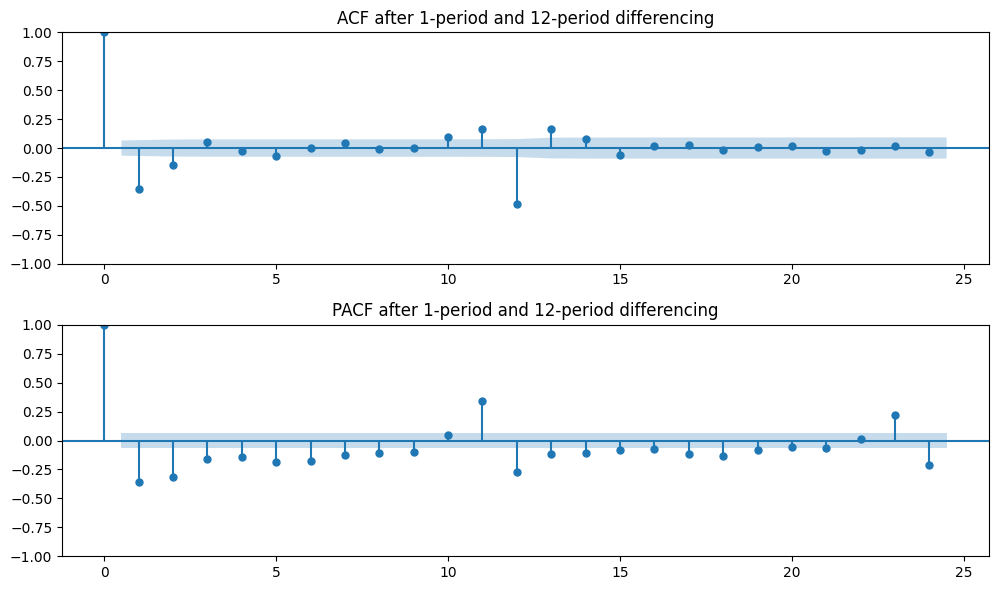

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# first difference to remove trend
monthly_diff = monthly.diff(1)

# Seasonal difference over 12 months to remove annual cycle
monthly_diff_seasonal = monthly_diff.diff(12)

# Drop NaN values created by differencing
ts = monthly_diff_seasonal.dropna()
print("Length of stationary series:", len(ts))

#ACF & PACF ON STATIONARY SERIES

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(ts, lags=24, ax=axes[0], title='ACF after 1-period and 12-period differencing')
plot_pacf(ts, lags=24, ax=axes[1], title='PACF after 1-period and 12-period differencing')

plt.tight_layout()
plt.show()

In [ ]:
# Seems like we can use SARIMA(1,1,1)(1,1,1,12) based on the ACF and PACF plots
# But AIC showed that SARIMA(1,1,1)(0,1,1,12) was better

## SARIMA (1, 1, 1)x(1, 1, 1, 12)

c:\Users\sebbe\Desktop\Skolsaker\Examensarbete\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                 tx   No. Observations:                  780
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1552.783
Date:                            Sun, 25 May 2025   AIC                           3115.566
Time:                                    16:35:42   BIC                           3138.686
Sample:                                01-31-1950   HQIC                          3124.473
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2946      0.034      8.722      0.000       0.228       0.361
ma.L1         -0.9858      0.009   

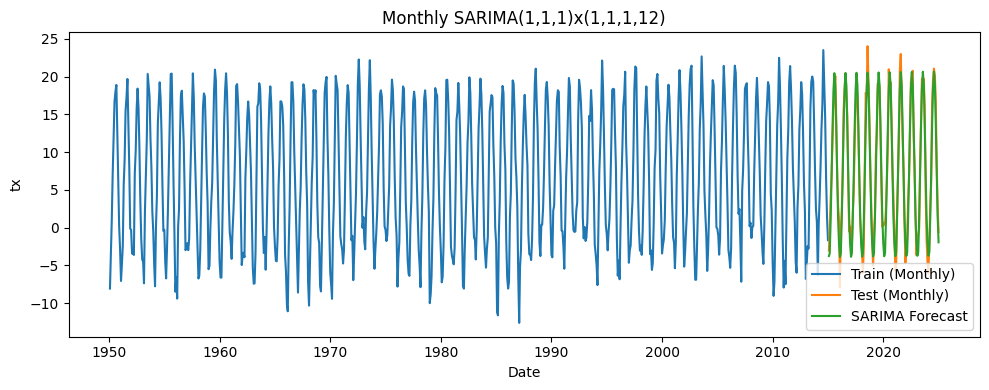

In [82]:
# Fit SARIMA with (1,1,1)x(1,1,1,12) to compare
model_m = SARIMAX(
    train_m,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_m = model_m.fit(disp=False, maxiter=20)
print(res_m.summary())

# Forecast
forecast_obj = res_m.get_prediction(start=test_m.index[0], end=test_m.index[-1])
forecast_m = forecast_obj.predicted_mean

# Evaluate
mae_m = mean_absolute_error(test_m, forecast_m)
print(f"\nMonthly SARIMA MAE: {mae_m:.3f}")
rmse_m = np.sqrt(np.mean((test_m - forecast_m) ** 2))
print(f"Monthly SARIMA RMSE: {rmse_m:.3f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(train_m, label='Train (Monthly)')
plt.plot(test_m,  label='Test (Monthly)')
plt.plot(forecast_m, label='SARIMA Forecast')
plt.title('Monthly SARIMA(1,1,1)x(1,1,1,12)')
plt.xlabel('Date')
plt.ylabel('tx')
plt.legend()
plt.tight_layout()
plt.show()


# Try to forecast

In [ ]:
# Sarima is worthless when it comes to forecasting. Should have used a different model. 
# Have wasted a lot of time with Holt-Winters, SARIMA, ARIMAX but none of these are good at forecasting.
# And also i need way more data for this

In [191]:
# Import and load again because of why not 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from statsmodels.tsa.statespace.sarimax import SARIMAX

engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df = pd.read_sql(
    """
    SELECT time, AVG(tg) AS tg
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')


In [192]:
# Set it to monthly means
monthly = df['tg'].resample('ME').mean()

# Train/test 
train_m = monthly.loc[:'2014-12']
test_m  = monthly.loc['2015-01':]

# fit the 0,1,1,12 model again 
model_m = SARIMAX(
    train_m,
    order=(1,1,1),
    seasonal_order=(0,1,1,12),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_m = model_m.fit(disp=False, maxiter=20)  

# forecast test period
forecast_in = res_m.get_prediction(start=test_m.index[0], end=test_m.index[-1])
fmean_in    = forecast_in.predicted_mean

# forecast a 10-year period
n_steps = 10 * 12  # 10 år * 12 mån
forecast_out = res_m.get_forecast(steps=n_steps)
fmean_out    = forecast_out.predicted_mean
conf_int     = forecast_out.conf_int()




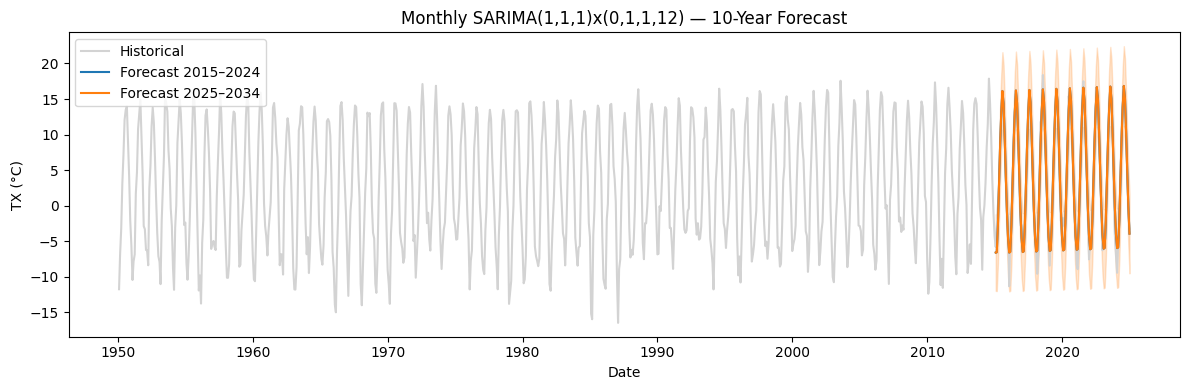

In [193]:

plt.figure(figsize=(12,4))

# Historik + test
plt.plot(monthly,               color='lightgray', label='Historical')
plt.plot(fmean_in, color='C0',  label='Forecast 2015–2024')

# Framtids-prognos
plt.plot(fmean_out, color='C1', label='Forecast 2025–2034')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='C1', alpha=0.2)

plt.title('Monthly SARIMA(1,1,1)x(0,1,1,12) — 10-Year Forecast')
plt.xlabel('Date')
plt.ylabel('TX (°C)')
plt.legend()
plt.tight_layout()
plt.show()

# Trying with Prophet instead and hopefully i get something i can use

In [ ]:
# Try with all variables 

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Create engine again
engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

# Load daily-mean series for all variables
df = pd.read_sql(
    """
    SELECT 
      time AS ds, 
      AVG(tg) AS y,   -- target: daily mean temperature
      AVG(tx) AS tx,  -- regressor: daily max temperature
      AVG(tn) AS tn,  -- regressor: daily min temperature
      AVG(rr) AS rr   -- regressor: daily precipitation
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time
    """,
    engine,
    parse_dates=['ds']
)

# Clean and inspect
df = df.dropna().reset_index(drop=True)  # drop any potential missing
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27394 entries, 0 to 27393
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      27394 non-null  datetime64[ns]
 1   y       27394 non-null  float64       
 2   tx      27394 non-null  float64       
 3   tn      27394 non-null  float64       
 4   rr      27394 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.0 MB
None
          ds          y         tx         tn        rr
0 1950-01-01 -11.890529  -8.302486 -16.899428  2.859057
1 1950-01-02 -12.028697  -8.606669 -16.156414  1.801606
2 1950-01-03 -14.442750 -10.750519 -17.382027  0.646542
3 1950-01-04 -18.512332 -13.831095 -21.984757  0.422993
4 1950-01-05 -20.766887 -16.753102 -24.637295  0.431577


19:14:34 - cmdstanpy - INFO - Chain [1] start processing
19:14:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sebbe\AppData\Local\Temp\ipykernel_91404\1540427300.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')


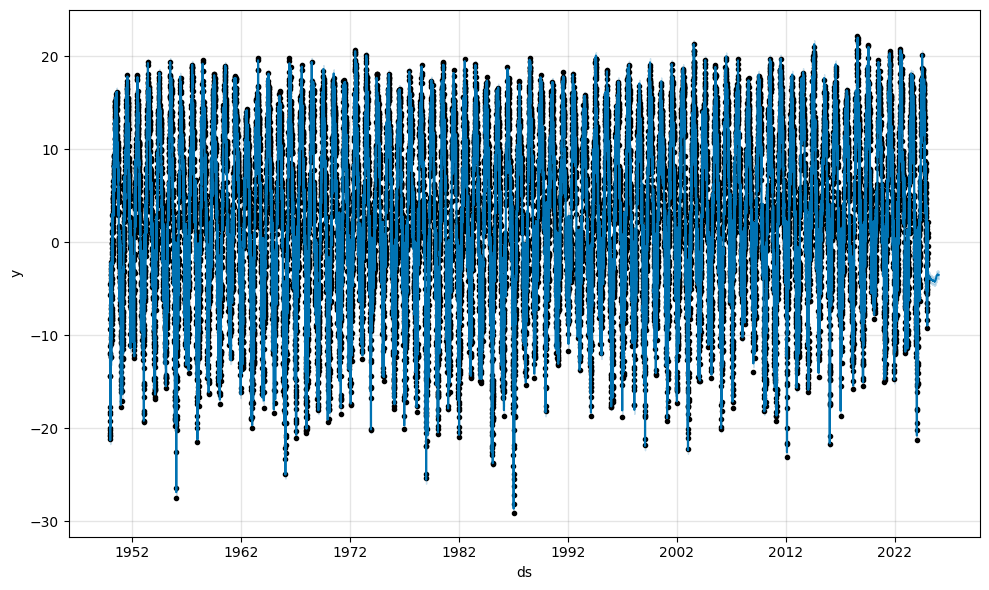

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from prophet import Prophet

# create new engine and load data
engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df = pd.read_sql(
    """
    SELECT time,
           AVG(tg) AS tg,
           AVG(tx) AS tx,
           AVG(tn) AS tn,
           AVG(rr) AS rr
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
)

#Build df_prophet 
df_prophet = (
    df
    .rename(columns={'time':'ds', 'tg':'y'}) 
    .loc[:, ['ds','y','tx','tn','rr']]        
    .dropna()                                  

# Instantiate Prophet and add the 3 regressors
m = Prophet()
m.add_regressor('tx')
m.add_regressor('tn')
m.add_regressor('rr')

# Fit the model
m.fit(df_prophet)

# Make a future frame (+365 days)
future = m.make_future_dataframe(periods=365)

#  Merge in your regressors for the future dates.
#    Here we simply carry forward the last observed value;
#    in practice you’d want a better exogenous forecast!
future = future.merge(
    df_prophet[['ds','tx','tn','rr']],
    on='ds',
    how='left'
).fillna(method='ffill')

# Forecast
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)


In [111]:
y_true_all = df_prophet['y']
y_pred_all = pred

mae_all  = mean_absolute_error(y_true_all, y_pred_all)
rmse_all = mean_squared_error(y_true_all, y_pred_all)

print(f"Prophet MAE (all history):  {mae_all:.2f}°C")
print(f"Prophet RMSE (all history): {rmse_all:.2f}°C")




Prophet MAE (all history):  0.24°C
Prophet RMSE (all history): 0.10°C


In [ ]:
# Model is way overfitting, so lets try to add some regularization and use cross_validation 

19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:15 - cmdstanpy - INFO - Chain [1] done processing


     horizon       mse      rmse       mae      mape
0    37 days  0.108763  0.329792  0.246872  0.331823
1    38 days  0.108999  0.330150  0.246873  0.332681
2    39 days  0.108255  0.329021  0.246055  0.332482
3    40 days  0.108116  0.328811  0.246262  0.330362
4    41 days  0.107883  0.328455  0.246286  0.329019
..       ...       ...       ...       ...       ...
324 361 days  0.106167  0.325833  0.245013  0.192425
325 362 days  0.106081  0.325701  0.245141  0.191530
326 363 days  0.106278  0.326003  0.245332  0.190165
327 364 days  0.105892  0.325411  0.244680  0.193885
328 365 days  0.105816  0.325294  0.244303  0.192043

[329 rows x 5 columns]


c:\Users\sebbe\Desktop\Skolsaker\Examensarbete\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\sebbe\Desktop\Skolsaker\Examensarbete\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


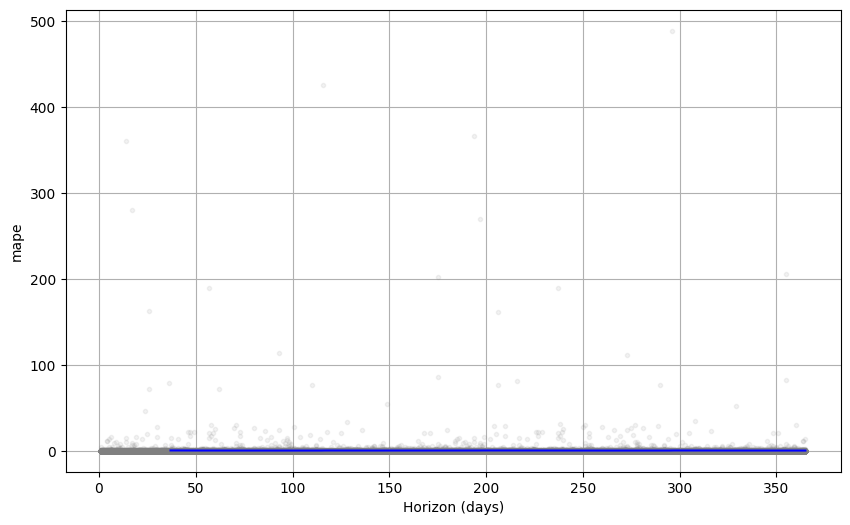

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt


df_prophet = (
    df
    .rename(columns={'time': 'ds', 'tg': 'y'})
    .loc[:, ['ds', 'y', 'tx', 'tn', 'rr']]
    .dropna()
)

# create new model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.add_regressor('tx')
m.add_regressor('tn')
m.add_regressor('rr')

m.fit(df_prophet)


# crossval it 
df_cv = cross_validation(
    model=m,
    initial='1095 days',
    period='180 days',
    horizon='365 days',
    parallel="processes"
)

# calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mse', 'rmse', 'mae', 'mape']])

# plot mape
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

In [ ]:
from prophet.diagnostics import performance_metrics

# assume df_cv is the output of prophet.diagnostics.cross_validation(...)
#  compute the error‐metrics table
df_p = performance_metrics(df_cv)

# now compute the averages
mean_mae  = df_p['mae'].mean()
mean_rmse = df_p['rmse'].mean()
mean_mape = df_p['mape'].mean() * 100

print(f"Average MAE:  {mean_mae:.3f} °C")
print(f"Average RMSE: {mean_rmse:.3f} °C")
print(f"Average MAPE: {mean_mape:.1f} %")



Average MAE:  0.244 °C
Average RMSE: 0.326 °C
Average MAPE: 22.2 %


In [ ]:
# still severly overfitting

08:22:22 - cmdstanpy - INFO - Chain [1] start processing
08:22:30 - cmdstanpy - INFO - Chain [1] done processing


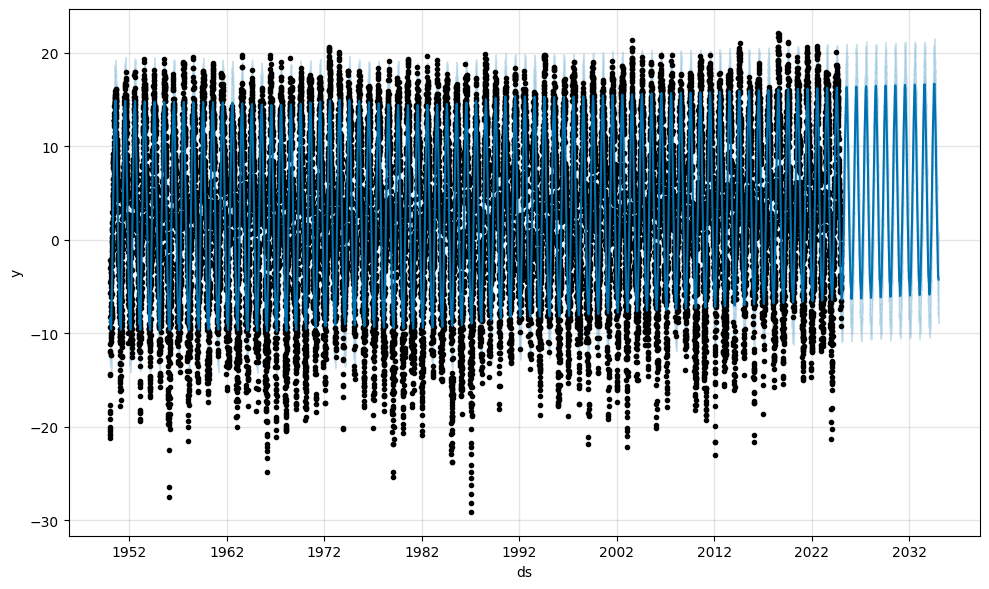

In [ ]:
from prophet import Prophet
import pandas as pd


# prophet with only tg
df_prophet = df_daily.reset_index()[['time','tg']].rename(columns={'time':'ds','tg':'y'})

# train without regressors
m = Prophet(yearly_seasonality=True, daily_seasonality=False)  
m.add_seasonality(name='daily', period=365, fourier_order=10)  
m.fit(df_prophet)

# try to forecast 10 years
future = m.make_future_dataframe(periods=3650, freq='D')

# forecast
forecast = m.predict(future)

# plot
fig1 = m.plot(forecast)
fig1.tight_layout()


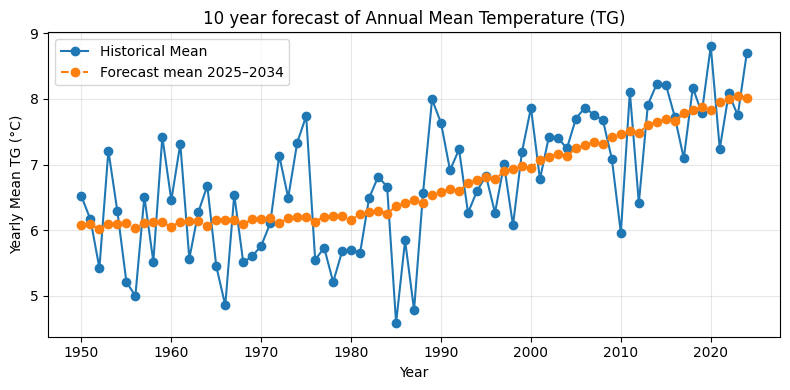

In [ ]:
# Try to forecast and plot 
forecast['year'] = forecast['ds'].dt.year
annual_forecast = forecast.groupby('year')['yhat'].mean().reset_index()

plt.figure(figsize=(8,4))

hist = df_prophet.copy()
hist['year'] = hist['ds'].dt.year
annual_hist = hist.groupby('year')['y'].mean()

plt.plot(annual_hist.index, annual_hist.values, marker='o', label='Historical Mean')
plt.plot(annual_forecast['year'], annual_forecast['yhat'],
         marker='o', linestyle='--', label='Forecast mean 2025–2034')
plt.xlabel('Year')
plt.ylabel('Yearly Mean TG (°C)')
plt.title('10 year forecast of Annual Mean Temperature (TG)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Alright, lets try monthly means and with sarima as well. Doesnt matter if result is good we just need something to show

# Try again with monthly means for both SARIMA and Prophet

In [ ]:
# Import and load again because of why not 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from statsmodels.tsa.statespace.sarimax import SARIMAX

engine = create_engine(
    "mssql+pyodbc://@localhost/WeatherData"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)
df = pd.read_sql(
    """
    SELECT time, AVG(tg) AS tg
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')


# Prophet test


In [205]:
import pandas as pd
from prophet import Prophet


df_prophet = df_monthly.reset_index().rename(columns={'time': 'ds', 'tg': 'y'})


In [206]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(df_prophet)


19:18:25 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing


In [207]:
from prophet.diagnostics import cross_validation, performance_metrics

# 
df_cv = cross_validation(
    m,
    initial='2555 days',  
    period='365 days',    
    horizon='1095 days'     
)

# calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mae', 'rmse', 'mape']])
df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p[['horizon','mae','rmse']])
print("Avg MAE:", df_p['mae'].mean(), "Avg RMSE:", df_p['rmse'].mean())


  0%|          | 0/65 [00:00<?, ?it/s]19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/65 [00:00<00:21,  3.01it/s]19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 2/65 [00:00<00:14,  4.45it/s]19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 3/65 [00:00<00:11,  5.24it/s]19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 4/65 [00:00<00:11,  5.45it/s]19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 5/65 [00:00<00:11,  5.37it/s]19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 6/65 [00:01<00:10,  5.38it/s]19:18:54

      horizon       mae      rmse       mape
0    113 days  2.221178  2.800831   4.038543
1    114 days  2.197251  2.779762   4.039057
2    115 days  2.147962  2.731374   4.038678
3    116 days  2.131228  2.720064   4.038604
4    117 days  2.080508  2.676058   4.036191
..        ...       ...       ...        ...
546 1091 days  1.528238  2.021272  36.562201
547 1092 days  1.556407  2.058336  36.577815
548 1093 days  1.561285  2.064382  36.586971
549 1094 days  1.589214  2.084961  36.595109
550 1095 days  1.589172  2.083906  36.595797

[551 rows x 4 columns]
    horizon       mae      rmse
0 1095 days  1.582688  2.095265
Avg MAE: 1.5826883614756138 Avg RMSE: 2.0952654172390903


11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sebbe\Desktop\Skolsaker\Examensarbete\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


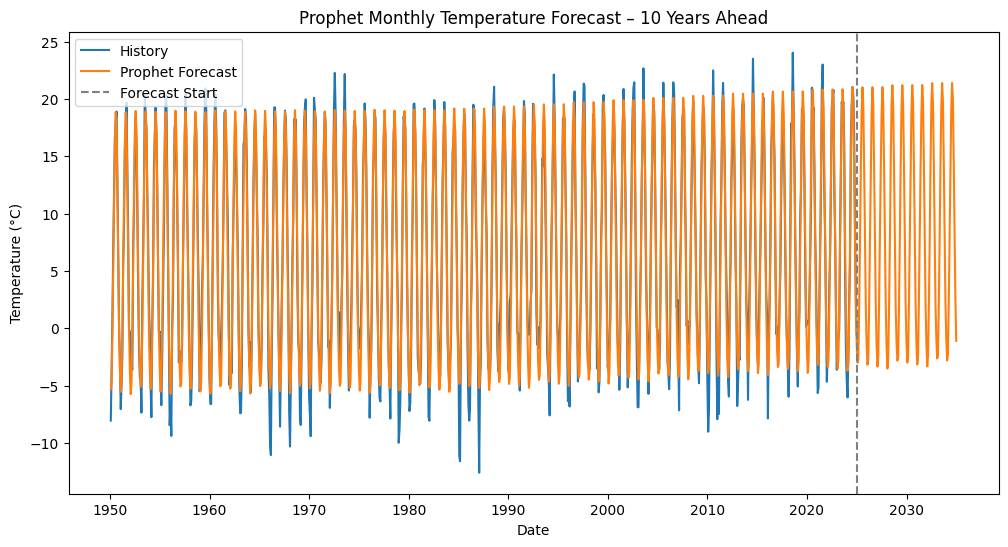

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# prepare data 
df_prophet = df_monthly.reset_index()
df_prophet.columns = ['ds', 'y']  # ds = datum, y = värde

# set up and fit on yearly seasonality
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(df_prophet)

# try to forecast 10 years
future = m.make_future_dataframe(periods=120, freq='M')

#forecast
forecast = m.predict(future)

# plot it 
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'],        label='History')
plt.plot(forecast['ds'],    forecast['yhat'],     label='Prophet Forecast')
plt.axvline(df_prophet['ds'].max(),
            linestyle='--', color='gray',       label='Forecast Start')
plt.legend(loc='upper left')
plt.title('Prophet Monthly Temperature Forecast – 10 Years Ahead')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


# Crossval with Prophet and final models here 

In [204]:
# load data again so we have right index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sqlalchemy import create_engine

df = pd.read_sql(
    """
    SELECT time, AVG(tg) AS tg
    FROM dbo.ClimateData_Norden
    GROUP BY time
    ORDER BY time;
    """,
    engine,
    parse_dates=['time']
).set_index('time')


In [208]:
# create df_monthly (1950-01 → 2024-12)
df_monthly = df['tg'].resample('ME').mean()

# 1Prepare Prophet DataFrame
df_prophet = df_monthly.reset_index().rename(columns={'time':'ds','tg':'y'})


# Fit on full history
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive' # added additive seasonality 
)
m.fit(df_prophet)

# Cross-validation
df_cv = cross_validation(
    m,
    initial='2555 days',   # ~7 years
    period='365 days',     # roll forward each year
    horizon='365 days',    # 1-year forecast
    parallel='processes'
)
df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p[['horizon','mae','rmse']])
print("Avg MAE:", df_p['mae'].mean(), "Avg RMSE:", df_p['rmse'].mean())

19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing


   horizon       mae      rmse
0 365 days  1.566284  2.074649
Avg MAE: 1.566283843123885 Avg RMSE: 2.074648530832876


In [ ]:
# seasonaliy mode='additive' # is better than multiplicative for this data

c:\Users\sebbe\Desktop\Skolsaker\Examensarbete\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


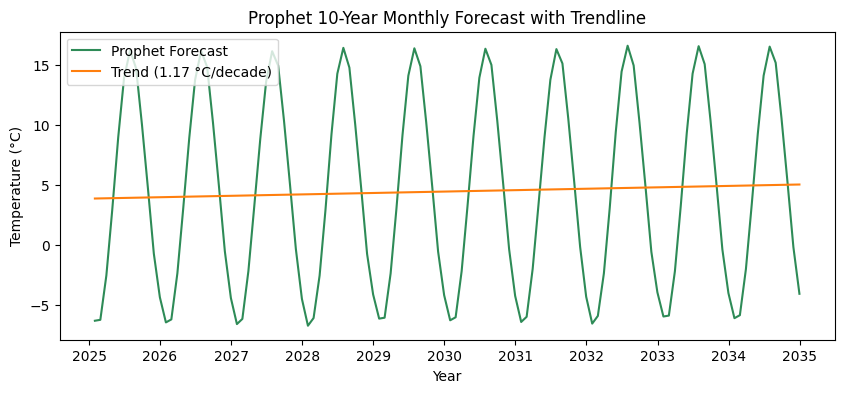

In [199]:
# Forecast next 10 years (120 months)
future = m.make_future_dataframe(periods=120, freq='M')
forecast = m.predict(future)
pred_future = forecast.set_index('ds')['yhat'].loc['2025-01-01':]

# Compute & plot trendline
years = pred_future.index.year + (pred_future.index.month - 1)/12
coef = np.polyfit(years, pred_future.values, 1)
trend = np.poly1d(coef)(years)

plt.figure(figsize=(10,4))
plt.plot(pred_future.index, pred_future, color='seagreen',label='Prophet Forecast')
plt.plot(pred_future.index, trend, color='tab:orange', label=f'Trend ({coef[0]*10:.2f} °C/decade)')
plt.legend(loc='upper left')
plt.title('Prophet 10-Year Monthly Forecast with Trendline')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()


# Calculate mean warming last 10 years. 

In [196]:
import numpy as np

# Extract last 10 years and fix index
last10 = df_monthly.last('10Y')
years = last10.index.year + (last10.index.month - 1) / 12

# find trendline coefficients
coef = np.polyfit(years, last10.values, 1)

# print
print(f"Mean warming last 10 years: {coef[0]*10:.3f} °C per decade")


Mean warming last 10 years: 1.056 °C per decade


C:\Users\sebbe\AppData\Local\Temp\ipykernel_91404\1937404135.py:4: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last10 = df_monthly.last('10Y')
C:\Users\sebbe\AppData\Local\Temp\ipykernel_91404\1937404135.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  last10 = df_monthly.last('10Y')


# Cross Val with SARIMA

In [203]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# df_monthly: pandas Series of monthly mean TG from 1950-01 to 2024-12

# Set up CV parameters to mirror Prophet's initial/period/horizon
initial_years = 7
period_months = 12
horizon_months = 12

n = len(df_monthly)
initial_n = initial_years * 12

results = []
fold = 1
start = initial_n

# Rolling-origin CV: train on increasing window, test next 12 months, then slide by 12 months
while start + horizon_months <= n:
    # Define training and test splits
    train_series = df_monthly.iloc[:start]
    test_series  = df_monthly.iloc[start:start + horizon_months]
    
    # Fit SARIMA on the training split
    model = SARIMAX(
        train_series,
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast the test horizon
    pred = model.get_forecast(steps=horizon_months).predicted_mean
    pred.index = test_series.index
    
    # Compute error metrics
    mae  = np.mean(np.abs(pred - test_series))
    rmse = np.sqrt(np.mean((pred - test_series)**2))
    
    results.append({
        'Fold': fold,
        'Train End': train_series.index[-1].strftime('%Y-%m'),
        'Test Start': test_series.index[0].strftime('%Y-%m'),
        'Test End': test_series.index[-1].strftime('%Y-%m'),
        'MAE': mae,
        'RMSE': rmse
    })
    
    # Move the window forward
    fold += 1
    start += period_months

# Compile results
df_sarima_cv = pd.DataFrame(results)
print(df_sarima_cv)
print(f"Average MAE: {df_sarima_cv['MAE'].mean():.3f}, Average RMSE: {df_sarima_cv['RMSE'].mean():.3f}")



    Fold Train End Test Start Test End       MAE      RMSE
0      1   1956-12    1957-01  1957-12  3.063578  3.418135
1      2   1957-12    1958-01  1958-12  1.343448  1.822101
2      3   1958-12    1959-01  1959-12  1.997448  2.706163
3      4   1959-12    1960-01  1960-12  1.400856  1.649160
4      5   1960-12    1961-01  1961-12  1.647877  2.184358
..   ...       ...        ...      ...       ...       ...
63    64   2019-12    2020-01  2020-12  2.021234  2.336567
64    65   2020-12    2021-01  2021-12  1.558595  1.779901
65    66   2021-12    2022-01  2022-12  1.249165  1.372051
66    67   2022-12    2023-01  2023-12  1.739557  2.055059
67    68   2023-12    2024-01  2024-12  1.283026  1.410678

[68 rows x 6 columns]
Average MAE: 1.582, Average RMSE: 2.005


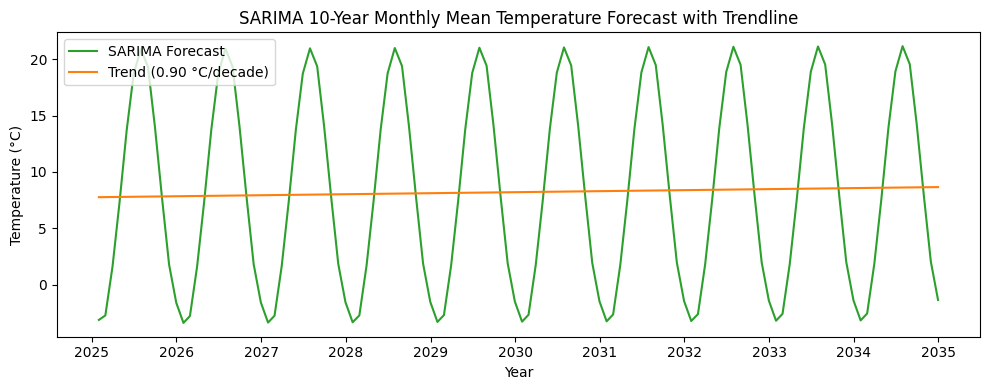

In [187]:
# Retrain the model on the full dataset for 10-year forecast
model_full = SARIMAX(
    pd.Series(y, index=dates),
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# forecast  
pred_future = model_full.get_forecast(steps=120).predicted_mean

# calculate trendline and plot 
years = pred_future.index.year + (pred_future.index.month - 1) / 12
coef = np.polyfit(years, pred_future.values, 1)
trend_line = np.poly1d(coef)(years)
trend_per_decade = coef[0] * 10

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(pred_future.index, pred_future, color='tab:green', label='SARIMA Forecast')
plt.plot(pred_future.index, trend_line, color='tab:orange',
         label=f'Trend ({trend_per_decade:.2f} °C/decade)')
plt.legend(loc='upper left')
plt.title('SARIMA 10-Year Monthly Mean Temperature Forecast with Trendline')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()